In [1]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms, datasets
from torchsummary import summary
from tqdm import tqdm

from PIL import Image

%matplotlib inline

In [2]:
dataset = datasets.CIFAR100(root='D:/Data/Study/cifar100', train=True, download=True)

Files already downloaded and verified


In [3]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [4]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    

In [5]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=32,
                          shuffle=False)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 60)
        self.out = torch.nn.Linear(60, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                   [-1, 60]          12,060
           Linear-12                  [-1, 100]           6,100
Total params: 196,806
Trainable params: 196,806
Non-trainable params: 0
-------------------------------

In [10]:
num_epochs = 10
net.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        if i % 300 == 0:
            net.eval()
            
            print(f'Epoch [{epoch + 1} / {num_epochs}]. ' \
                  f'Step [{i + 1} / {len(train_loader)}].' \
                  f'Loss {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            
            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader, 0):
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
            
        net.train()

print('Training is finished!')

Epoch [1 / 10]. Step [1 / 1485].Loss 0.143. Acc: 0.031. Test acc: 0.012
Epoch [1 / 10]. Step [301 / 1485].Loss 0.144. Acc: 0.010. Test acc: 0.007
Epoch [1 / 10]. Step [601 / 1485].Loss 0.144. Acc: 0.008. Test acc: 0.011
Epoch [1 / 10]. Step [901 / 1485].Loss 0.144. Acc: 0.011. Test acc: 0.009
Epoch [1 / 10]. Step [1201 / 1485].Loss 0.144. Acc: 0.011. Test acc: 0.012
Epoch [2 / 10]. Step [1 / 1485].Loss 0.145. Acc: 0.000. Test acc: 0.008
Epoch [2 / 10]. Step [301 / 1485].Loss 0.144. Acc: 0.009. Test acc: 0.011
Epoch [2 / 10]. Step [601 / 1485].Loss 0.144. Acc: 0.009. Test acc: 0.010
Epoch [2 / 10]. Step [901 / 1485].Loss 0.144. Acc: 0.010. Test acc: 0.010
Epoch [2 / 10]. Step [1201 / 1485].Loss 0.144. Acc: 0.010. Test acc: 0.009
Epoch [3 / 10]. Step [1 / 1485].Loss 0.144. Acc: 0.031. Test acc: 0.011
Epoch [3 / 10]. Step [301 / 1485].Loss 0.144. Acc: 0.011. Test acc: 0.008
Epoch [3 / 10]. Step [601 / 1485].Loss 0.144. Acc: 0.011. Test acc: 0.010
Epoch [3 / 10]. Step [901 / 1485].Loss 0.1

In [11]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [12]:
for param in resnet.parameters():
    param.requires_grad = False

In [13]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features = 100)
resnet.fc = fc
summary(resnet.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [15]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [16]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
test_dataset = MyOwnCifar(test_dataset, test_transforms)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=8,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=8,
                                           shuffle=False)

In [18]:
def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses, acc_train, acc_val = [], [], [], []
    
    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        print(f'Epoch [{epoch + 1}] / [{num_epoch}].')
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            output = model(images)
            loss = criterion(output, labels)
            
            correct_train += (torch.max(output, dim=1)[1]==labels).sum()
            total_train += labels.size(0)
            
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Logging
            if steps % print_every == 0:
                pass
        print(f'Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
        print(f'Train Loss {running_loss / steps:.3f}.', end=' ')
        print(f'Train acc: {correct_train / total_train:.3f}', end=' ')
        with torch.no_grad():
            model.eval()
            correct_val, total_val = 0, 0
            val_loss = 0
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
                correct_val += (torch.max(output, dim=1)[1]==labels).sum()
                total_val += labels.size(0)
            torch.cuda.empty_cache()
        print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val:.3f}.', end = ' ')
        print(f'Took {time() - iter_time:.3f} seconds')
        iter_time = time()

        acc_train.append(correct_train / total_train)
        acc_val.append(correct_val / total_val)
        train_losses.append(running_loss / total_train)
        val_losses.append(val_loss / total_val)
        print(f'Epoch took {(time()-start_time)/60:.1f} minutes')
        
        torch.save(model, f'checkpoint_{correct_val /total_val*100:.2f}')
    return model, train_losses, val_losses, acc_train, acc_val

In [19]:
print_every = 1000
num_epoch = 10
torch.cuda.empty_cache()
resnet, train_losses, val_losses, acc_train, acc_val = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch [1] / [10].
Batch [5938]/[5938]. Train Loss 2.884. Train acc: 0.325 Val loss 2.089. Val acc 0.499. Took 1121.734 seconds
Epoch took 18.7 minutes


 10%|███████▉                                                                       | 1/10 [18:41<2:48:17, 1121.97s/it]

Epoch [2] / [10].
Batch [5938]/[5938]. Train Loss 1.283. Train acc: 0.407 Val loss 2.404. Val acc 0.469. Took 1115.104 seconds
Epoch took 18.6 minutes


 20%|███████████████▊                                                               | 2/10 [37:17<2:29:04, 1118.07s/it]

Epoch [3] / [10].
Batch [5938]/[5938]. Train Loss 0.835. Train acc: 0.429 Val loss 2.157. Val acc 0.506. Took 1116.624 seconds
Epoch took 18.6 minutes


 30%|███████████████████████▋                                                       | 3/10 [55:54<2:10:22, 1117.54s/it]

Epoch [4] / [10].
Batch [5938]/[5938]. Train Loss 0.621. Train acc: 0.439 Val loss 2.093. Val acc 0.526. Took 1099.730 seconds
Epoch took 18.3 minutes


 40%|██████████████████████████████▊                                              | 4/10 [1:14:14<1:51:03, 1110.60s/it]

Epoch [5] / [10].
Batch [5938]/[5938]. Train Loss 0.492. Train acc: 0.447 Val loss 2.200. Val acc 0.510. Took 1098.391 seconds
Epoch took 18.3 minutes


 50%|██████████████████████████████████████▌                                      | 5/10 [1:32:32<1:32:11, 1106.28s/it]

Epoch [6] / [10].
Batch [5938]/[5938]. Train Loss 0.406. Train acc: 0.453 

 60%|██████████████████████████████████████████████▏                              | 6/10 [1:50:48<1:13:31, 1102.79s/it]

Val loss 2.169. Val acc 0.540. Took 1095.800 seconds
Epoch took 18.3 minutes
Epoch [7] / [10].
Batch [5938]/[5938]. Train Loss 0.343. Train acc: 0.461 Val loss 2.326. Val acc 0.498. Took 1085.901 seconds
Epoch took 18.1 minutes


 70%|███████████████████████████████████████████████████████▎                       | 7/10 [2:08:54<54:52, 1097.34s/it]

Epoch [8] / [10].
Batch [5938]/[5938]. Train Loss 0.298. Train acc: 0.465 Val loss 2.130. Val acc 0.529. Took 1437.732 seconds
Epoch took 24.0 minutes


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [2:32:53<40:11, 1205.82s/it]

Epoch [9] / [10].
Batch [5938]/[5938]. Train Loss 0.263. Train acc: 0.470 Val loss 2.127. Val acc 0.543. Took 1329.389 seconds
Epoch took 22.2 minutes


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [2:55:02<20:44, 1244.55s/it]

Epoch [10] / [10].
Batch [5938]/[5938]. Train Loss 0.235. Train acc: 0.472 Val loss 2.152. Val acc 0.544. Took 1218.602 seconds
Epoch took 20.3 minutes


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [3:15:21<00:00, 1172.18s/it]


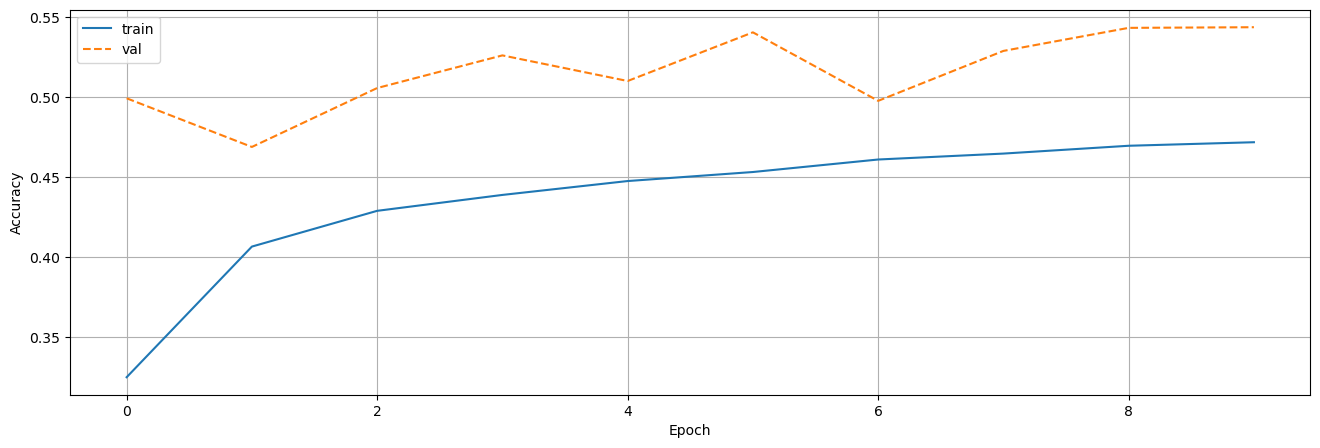

In [20]:
plt.figure(figsize = (16,5))
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_train)).insert(0, 0),'-',label = f'train')
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_val)).insert(0, 0),'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

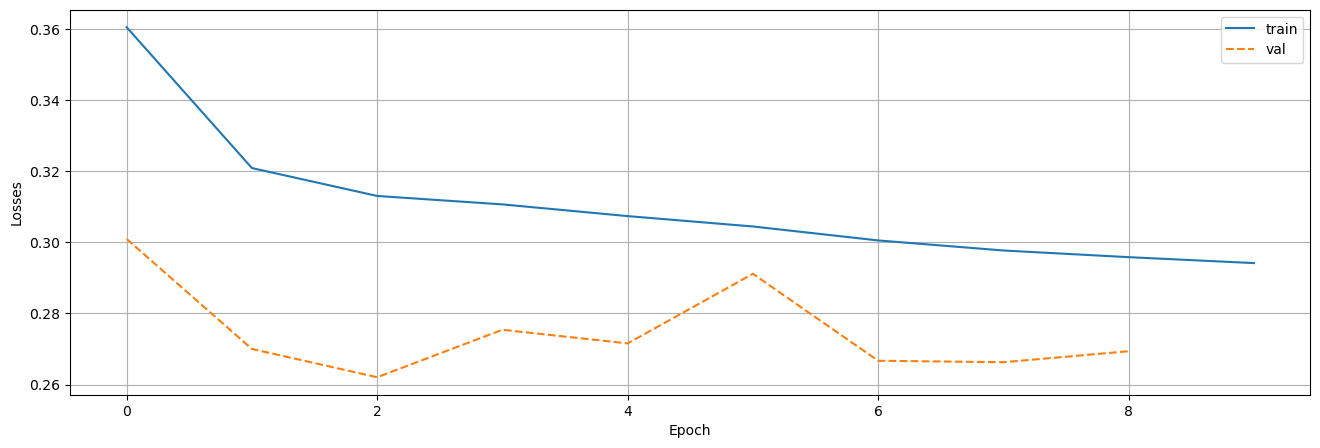

In [28]:
plt.figure(figsize = (16,5))
plt.plot(train_losses,'-',label = f'train')
plt.plot(val_losses,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.grid()
plt.show()  

In [27]:
train_losses

[0.3604719797096754,
 0.3208838550423321,
 0.31303493868426274,
 0.3106643082882229,
 0.3073712140663674,
 0.3044563521127952,
 0.3005308432695113,
 0.29770352304891534,
 0.2958290978770507,
 0.29416345236928837]